In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files

In [2]:
#Need to split the Train Set for clusters then combine with new Train of 5 seasons
nba_clustered = pd.read_csv("NBA_Train_Clustered.csv")
labels = nba_clustered[["PLAYER",'Cluster',"Cluster_Label"]]

nba_5Season_train = pd.read_csv("5YearSplitTraining.csv")
nba_clustered = nba_5Season_train.merge(labels, on='PLAYER', how='inner')
nba_clustered


,PLAYER,GP,MIN,PTS,REB,AST,STL,BLK,FG_PCT,FG3_PCT,FT_PCT,TOV,Cluster,Cluster_Label
0,A.C. Green,82.000000,17.200000,4.500000,3.800000,0.50,0.400000,0.100000,0.444000,0.0000,0.712000,0.500000,3,Bench
1,A.J. Guyton,39.000000,16.200000,5.700000,1.050000,1.85,0.250000,0.200000,0.383500,0.3825,0.824000,0.750000,4,Bust
2,AJ Hammons,22.000000,7.400000,2.200000,1.600000,0.20,0.000000,0.600000,0.405000,0.5000,0.450000,0.500000,4,Bust
3,AJ Price,47.000000,14.040000,5.400000,1.360000,2.04,0.460000,0.040000,0.381600,0.3076,0.611400,0.860000,4,Bust
4,Aaron Brooks,65.000000,22.620000,10.760000,1.700000,3.22,0.580000,0.140000,0.415400,0.3528,0.840000,1.660000,2,Role Player
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,Zeljko Rebraca,43.000000,14.720000,5.560000,2.960000,0.36,0.240000,0.700000,0.521800,0.0000,0.789000,0.880000,3,Bench
1551,Zendon Hamilton,50.000000,12.950000,4.850000,3.950000,0.30,0.300000,0.250000,0.478500,0.0000,0.675000,0.850000,3,Bench
1552,Zion Williamson,24.000000,27.800000,22.500000,6.300000,2.10,0.700000,0.400000,0.583000,0.4290,0.640000,2.500000,0,Superstar
1553,Zoran Planinic,49.333333,10.666667,3.833333,1.333333,1.10,0.433333,0.066667,0.406667,0.2960,0.675667,0.833333,4,Bust


In [3]:
ncaa_train = pd.read_csv("College2000_2020.csv")

print(f" NBA data: {len(nba_clustered)} players")
print(f" NCAA data: {len(ncaa_train)} players")

# Merge
merged_train = pd.merge(
    ncaa_train,
    nba_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged: {len(merged_train)} players")
print(f"\nCluster distribution:")
print(merged_train['Cluster_Label'].value_counts())

 NBA data: 1555 players
 NCAA data: 1233 players
 Merged: 1137 players

Cluster distribution:
Cluster_Label
Bust                360
Role Player         326
Bench               224
Superstar           140
All-Star/Starter     87
Name: count, dtype: int64


In [4]:
# College features (same as Logistic Regression)
college_features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'
]

# Check which features exist
available_features = [f for f in college_features if f in merged_train.columns]
print(f" Available features ({len(available_features)}): {available_features}")

# Create X and y
X = merged_train[available_features].copy()
y = merged_train['Cluster'].copy()

# Handle missing values
X = X.fillna(X.mean())

print(f"\n Feature matrix: {X.shape}")
print(f" Target distribution:")
print(y.value_counts().sort_index())

 Available features (17): ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

 Feature matrix: (1137, 17)
 Target distribution:
Cluster
0    140
1     87
2    326
3    224
4    360
Name: count, dtype: int64


In [5]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Training: {len(X_train)} samples")
print(f" Testing: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Features scaled (mean=0, std=1)")

 Training: 909 samples
 Testing: 228 samples
 Features scaled (mean=0, std=1)


In [6]:
# Train model
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



 Training Accuracy: 0.5325 (53.25%)
 Test Accuracy: 0.4956 (49.56%)


In [7]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test, y_test_pred,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.419     0.643     0.507        28
    All-Star      0.357     0.556     0.435        18
 Role Player      0.468     0.446     0.457        65
       Bench      0.549     0.622     0.583        45
        Bust      0.636     0.389     0.483        72

    accuracy                          0.496       228
   macro avg      0.486     0.531     0.493       228
weighted avg      0.522     0.496     0.494       228



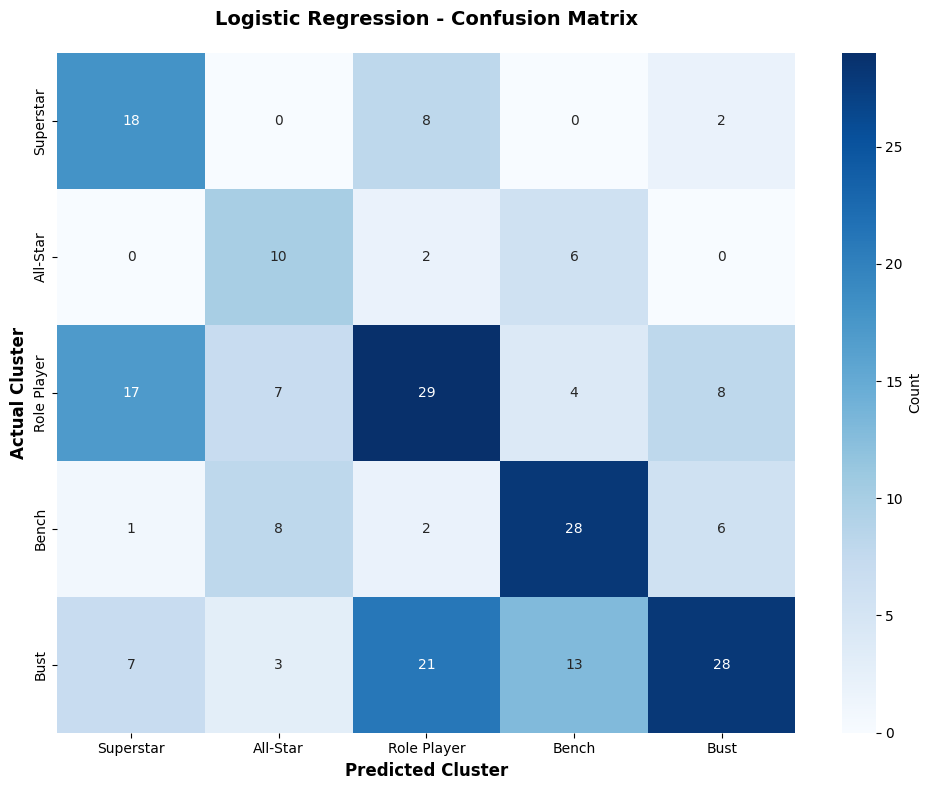


Confusion Matrix (Actual vs Predicted):
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                18              0                 8   
Actual All-Star                  0             10                 2   
Actual Role Player              17              7                29   
Actual Bench                     1              8                 2   
Actual Bust                      7              3                21   

                    Pred Bench  Pred Bust  
Actual Superstar             0          2  
Actual All-Star              6          0  
Actual Role Player           4          8  
Actual Bench                28          6  
Actual Bust                 13         28  


In [8]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Logistic Regression - Confusion Matrix',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix (Actual vs Predicted):")
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)


 Top 10 Most Important Features:
Feature  Importance
    FGA    0.554939
    3PA    0.492703
    AST    0.488169
    BLK    0.463140
    PTS    0.422185
     MP    0.401481
    STL    0.373441
    FTA    0.358427
    TRB    0.352349
     FG    0.347018


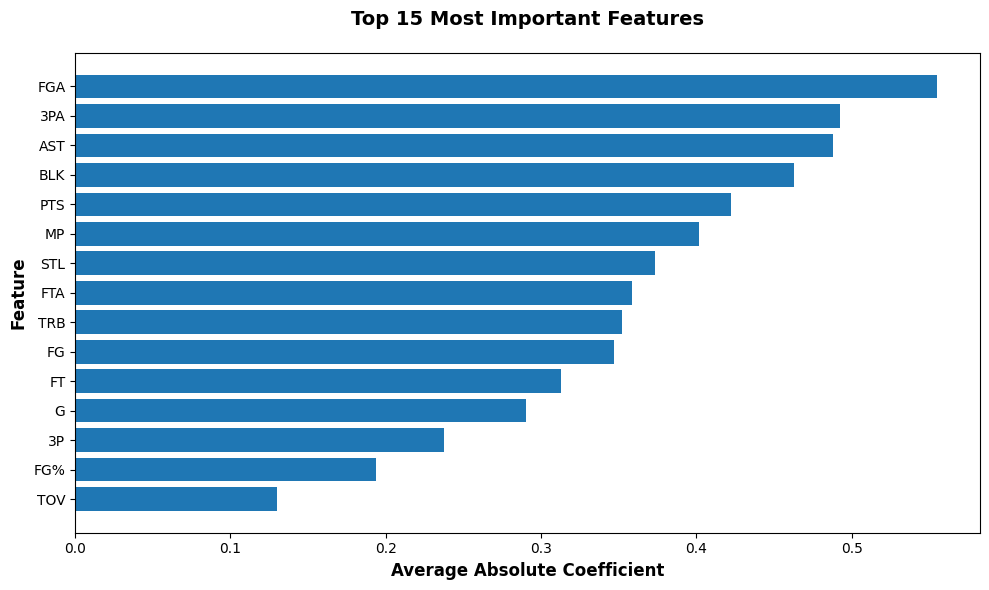

In [9]:
# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': np.abs(log_reg.coef_).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_n = 15
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Average Absolute Coefficient', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
print(f"Model: Logistic Regression (Multinomial)")
print(f"Total Players: {len(merged_train)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Number of Features: {len(available_features)}")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Model: Logistic Regression (Multinomial)
Total Players: 1137
Training Samples: 909
Test Samples: 228
Number of Features: 17
Training Accuracy: 0.5325 (53.25%)
Test Accuracy: 0.4956 (49.56%)


# Testing with NBA players from 2020-2025

 Test set: 247 players

 Test Accuracy for NBA Players (2020-2025): 0.4575 (45.75%)
              precision    recall  f1-score   support

   Superstar      0.231     0.462     0.308        13
    All-Star      0.200     0.778     0.318         9
 Role Player      0.427     0.400     0.413        80
       Bench      0.400     0.333     0.364        24
        Bust      0.659     0.496     0.566       121

    accuracy                          0.457       247
   macro avg      0.383     0.494     0.394       247
weighted avg      0.519     0.457     0.474       247



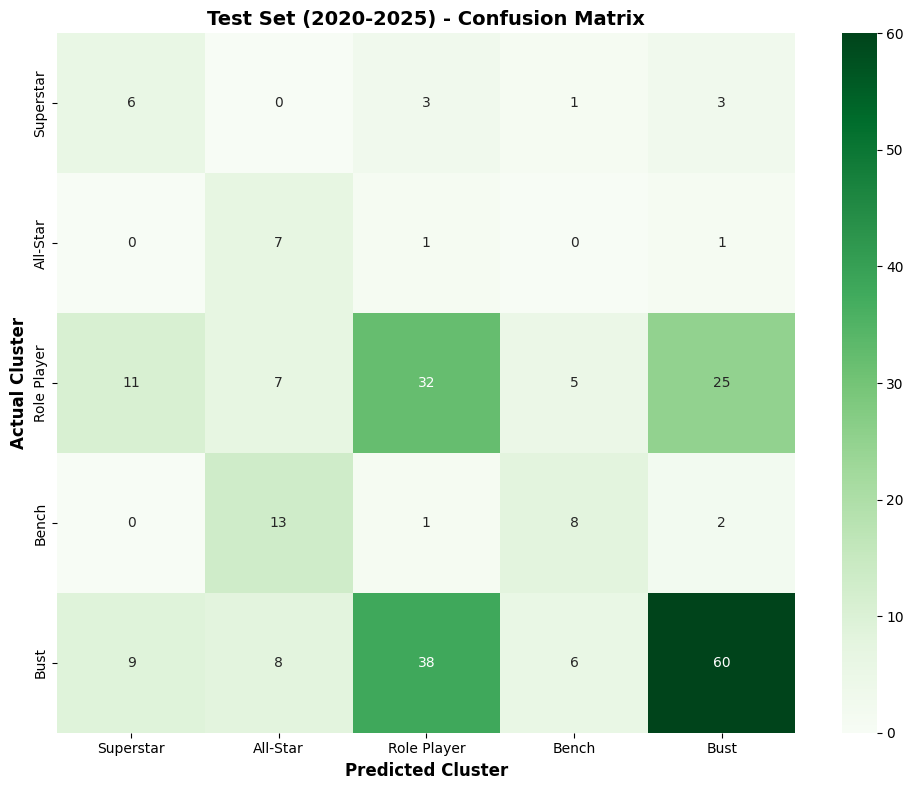

PREDICTION EXAMPLES

 Correct Predictions:
            Name  PTS    Cluster_Label Predicted_Label
      Sam Hauser 13.3             Bust            Bust
     Jalen Duren 12.0 All-Star/Starter        All-Star
 Justin Robinson 11.4             Bust            Bust
  Kyshawn George  7.6      Role Player     Role Player
     Sam Merrill 16.8             Bust            Bust
     Gradey Dick 14.1      Role Player     Role Player
Collin Gillespie 11.9             Bust            Bust
   Aaron Nesmith 14.7      Role Player     Role Player
     Jalen Suggs 14.4        Superstar       Superstar
     Evan Mobley 16.4 All-Star/Starter        All-Star

 Incorrect Predictions:
            Name  PTS Cluster_Label Predicted_Label
   Jalen Johnson  5.6   Role Player            Bust
 Enrique Freeman 14.0          Bust        All-Star
  Omer Yurtseven 12.1         Bench        All-Star
    Cole Anthony 18.5   Role Player       Superstar
   Johnny Furphy  9.0          Bust     Role Player
  Udoka Azubuik

In [11]:
# Load data
ncaa_test = pd.read_csv("NCAA_2020_2025.csv")
nba_test_clustered = pd.read_csv("NBA_Test_Clustered.csv")

# Merge
merged_test = pd.merge(
    ncaa_test,
    nba_test_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Test set: {len(merged_test)} players")

# Prepare features
X_test_real = merged_test[available_features].copy()
y_test_real = merged_test['Cluster'].copy()
X_test_real = X_test_real.fillna(X_test_real.mean())

# Scale
X_test_real_scaled = scaler.transform(X_test_real)

# Predict
y_test_real_pred = log_reg.predict(X_test_real_scaled)

# Evaluate
test_acc_real = accuracy_score(y_test_real, y_test_real_pred)

print(f"\n Test Accuracy for NBA Players (2020-2025): {test_acc_real:.4f} ({test_acc_real*100:.2f}%)")

print(classification_report(y_test_real, y_test_real_pred,
                          target_names=cluster_names,
                          digits=3))

# Confusion Matrix
cm_test = confusion_matrix(y_test_real, y_test_real_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=cluster_names,
            yticklabels=cluster_names)
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Test Set (2020-2025) - Confusion Matrix',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("PREDICTION EXAMPLES")

merged_test['Predicted_Cluster'] = y_test_real_pred
merged_test['Predicted_Label'] = [cluster_names[p] for p in y_test_real_pred]
merged_test['Correct'] = merged_test['Cluster'] == merged_test['Predicted_Cluster']

print("\n Correct Predictions:")
correct = merged_test[merged_test['Correct'] == True].sample(min(10, len(merged_test)))
print(correct[['Name', 'PTS', 'Cluster_Label', 'Predicted_Label']].to_string(index=False))

print("\n Incorrect Predictions:")
incorrect = merged_test[merged_test['Correct'] == False].sample(min(10, len(merged_test[merged_test['Correct'] == False])))
print(incorrect[['Name', 'PTS', 'Cluster_Label', 'Predicted_Label']].to_string(index=False))